-  Date: 11/21
-  Notebook Owner: Reza Naiman
    
    
    
# Key findings

## Model Performance
- The combined weather and flight data model performed the best overall, with accuracies of 0.65 (training), 0.57 (validation), and 0.56 (testing). This indicates that combining weather and flight data provides a more comprehensive view for predictions.


- The weather-only model achieved similar validation and testing accuracies (0.57 and 0.56, respectively) but slightly lower training accuracy (0.62), suggesting weather data alone captures significant but not all predictive signals.

- The flight-only model showed the weakest performance, particularly on the validation set (accuracy: 0.38), highlighting that flight data alone may not be sufficient for reliable predictions.

## Feature Importance
- Weather Features:
   - The most critical weather features were Apparent Temperature Fahrenheit and Hourly Precipitation Inches, appearing in both the combined and weather-only models.This emphasizes the impact of weather conditions on the outcomes.
- Flight Features:
   - Day of Month and Scheduled Departure Time were the key features in the flight-only model, suggesting that scheduling and timing are relevant but not as impactful as weather-related factors.
   
## Suggestions
- Combining weather and flight data is essential for better predictive performance, as no single dataset is sufficient on its own.Weather conditions, particularly temperature and precipitation, consistently stand out as critical predictive factors based on the Decision Tree Models.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import shap


In [35]:
# Load and inspect the data
df = pd.read_csv("C:/Users/rezan/OneDrive/Documents/Fall 2024/Capstone/Illinois_10_years_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Quarter                           int64  
 2   Month                             int64  
 3   Day_of_Month                      float64
 4   Day_of_Week                       float64
 5   Operating_Carrier_Code            object 
 6   Tail_Number                       object 
 7   Origin_Airport_ID                 float64
 8   Origin_Airport_Code               object 
 9   Origin_State_Name                 object 
 10  Destination_Airport_Code          object 
 11  Destination_State_Name            object 
 12  Scheduled_Departure_Time          float64
 13  Departure_Delay_Minutes           float64
 14  Taxi_Out_Time_Minutes             float64
 15  Flight_Distance_Miles             float64
 16  Departure_Datetime                ob

In [36]:
# Drop unnecessary columns
df = df.drop(['Origin_State_Name', 'Departure_Datetime', 'Departure_Delay_Minutes','Taxi_Out_Time_Minutes'], axis=1)

In [37]:
# Convert integer features to int32
int_columns = [
    'Year', 
    'Quarter', 
    'Month', 
    'Day_of_Month', 
    'Day_of_Week', 
    'Scheduled_Departure_Time', 
    'Scheduled_Departure_Time_Minutes',
    'Target'
]

for col in int_columns:
    df[col] = df[col].astype(np.int32)

In [38]:
# Convert continuous numeric features to float32
float_columns = [
    
    'Flight_Distance_Miles',
    'Air_Temperature_Fahrenheit',
    'Dew_Point_Temperature_Fahrenheit',
    'Relative_Humidity_Percent',
    'Wind_Direction_Degrees',
    'Wind_Speed_Knots',
    'Hourly_Precipitation_Inches',
    'Pressure_Altimeter_Inches',
    'Sea_Level_Pressure_Millibar',
    'Visibility_Miles',
    'Sky_Level_1_Altitude_Feet',
    'Apparent_Temperature_Fahrenheit',
]

for col in float_columns:
    df[col] = df[col].astype(np.float32)

In [39]:
# Convert categorical features to 'category' dtype
categorical_columns = [
    'Operating_Carrier_Code',
    'Tail_Number',
    'Origin_Airport_ID',
    'Origin_Airport_Code',
    'Destination_Airport_Code',
    'Destination_State_Name',
    'Sky_Cover_Level_1'
]

for col in categorical_columns:
    df[col] = df[col].astype('category')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 27 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   Year                              int32   
 1   Quarter                           int32   
 2   Month                             int32   
 3   Day_of_Month                      int32   
 4   Day_of_Week                       int32   
 5   Operating_Carrier_Code            category
 6   Tail_Number                       category
 7   Origin_Airport_ID                 category
 8   Origin_Airport_Code               category
 9   Destination_Airport_Code          category
 10  Destination_State_Name            category
 11  Scheduled_Departure_Time          int32   
 12  Flight_Distance_Miles             float32 
 13  Scheduled_Departure_Time_Minutes  int32   
 14  Air_Temperature_Fahrenheit        float32 
 15  Dew_Point_Temperature_Fahrenheit  float32 
 16  Relative_Humidity_

In [41]:
# Filter data for January and reset the Year type
df1 = df[df['Month'] == 1]
df1['Year'] = df1['Year'].astype(int)

C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\379487763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Year'] = df1['Year'].astype(int)


In [42]:
# Define years for train, validation, and test sets
train_years = [2014, 2015, 2016, 2017, 2018, 2019]
val_years = [2020, 2021, 2022]
test_years = [2023, 2024]

In [43]:
# Split data into train, validation, and test sets
train_df = df1[df1['Year'].isin(train_years)].reset_index(drop=True)
val_df = df1[df1['Year'].isin(val_years)].reset_index(drop=True)
test_df = df1[df1['Year'].isin(test_years)].reset_index(drop=True)

## This model is for Flights and Weather Data combined

In [44]:
# Separate features and target
X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
X_val = val_df.drop('Target', axis=1)
y_val = val_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

In [45]:
X_train.head()

,Year,Quarter,Month,Day_of_Month,Day_of_Week,Operating_Carrier_Code,Tail_Number,Origin_Airport_ID,Origin_Airport_Code,Destination_Airport_Code,...,Relative_Humidity_Percent,Wind_Direction_Degrees,Wind_Speed_Knots,Hourly_Precipitation_Inches,Pressure_Altimeter_Inches,Sea_Level_Pressure_Millibar,Visibility_Miles,Sky_Cover_Level_1,Sky_Level_1_Altitude_Feet,Apparent_Temperature_Fahrenheit
0,2014,1,1,1,3,AA,N363AA,13930.0,ORD,MIA,...,77.449997,60.0,14.0,0.020000,30.0,1025.099976,0.625,VV,1200.0,7.26
1,2014,1,1,1,3,AA,N372AA,13930.0,ORD,HNL,...,79.980003,350.0,7.0,0.000000,30.0,1025.099976,7.750,OVC,1300.0,3.17
2,2014,1,1,1,3,AA,N3AFAA,13930.0,ORD,BOS,...,77.449997,70.0,12.0,0.026667,30.0,1025.699951,0.750,BKN,1300.0,8.03
3,2014,1,1,1,3,AA,N3AHAA,13930.0,ORD,FLL,...,77.449997,50.0,11.0,0.027500,30.0,1024.099976,0.750,VV,1400.0,8.45
4,2014,1,1,1,3,AA,N3ANAA,13930.0,ORD,MIA,...,79.830002,270.0,8.0,0.001250,30.0,1025.500000,6.000,OVC,1200.0,0.34


In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158523 entries, 0 to 158522
Data columns (total 26 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Year                              158523 non-null  int32   
 1   Quarter                           158523 non-null  int32   
 2   Month                             158523 non-null  int32   
 3   Day_of_Month                      158523 non-null  int32   
 4   Day_of_Week                       158523 non-null  int32   
 5   Operating_Carrier_Code            158523 non-null  category
 6   Tail_Number                       158523 non-null  category
 7   Origin_Airport_ID                 158523 non-null  category
 8   Origin_Airport_Code               158523 non-null  category
 9   Destination_Airport_Code          158523 non-null  category
 10  Destination_State_Name            158523 non-null  category
 11  Scheduled_Departure_Time          15852

In [47]:
# Ensure consistent encoding across all sets using pd.Categorical
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = pd.Categorical(X_train[col])
    X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
    X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

# Convert categorical columns to integer codes
X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val = X_val.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

<AxesSubplot:xlabel='Class', ylabel='Count'>

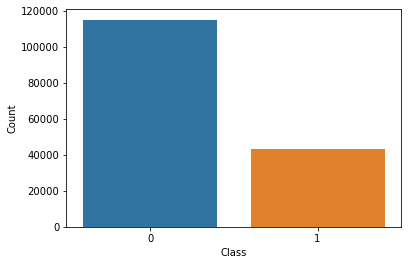

In [48]:
counts_1 = pd.Series(train_df["Target"]).value_counts()
class_counts_df_1 = counts_1.reset_index()
class_counts_df_1.columns = ['Class', 'Count']
sns.barplot(x='Class', y='Count', data=class_counts_df_1)

Based on this bar plot we can see the unbalanced distribution between the two different classes. Therefore, we need to apply SMOTE for class balancing.

In [49]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='Class', ylabel='Count'>

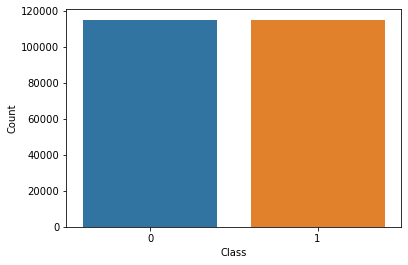

In [50]:
counts_2 = pd.Series(y_train_smote).value_counts()
class_counts_df_2 = counts_2.reset_index()
class_counts_df_2.columns = ['Class', 'Count']
sns.barplot(x='Class', y='Count', data=class_counts_df_2)

The classes are balanced, we are ready to train the decision tree!

In [51]:
jan_clf_1 = DecisionTreeClassifier(
    max_depth=5, 
    max_leaf_nodes=6,
    min_impurity_decrease=0.01,
    random_state=42
)
jan_clf_1.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=6,
                       min_impurity_decrease=0.01, random_state=42)

In [52]:
y_train_pred = jan_clf_1.predict(X_train_smote)
accuracy_training = round(accuracy_score(y_train_smote, y_train_pred), 2)
print("The accuracy for the training set is :" , accuracy_training)


The accuracy for the training set is : 0.65


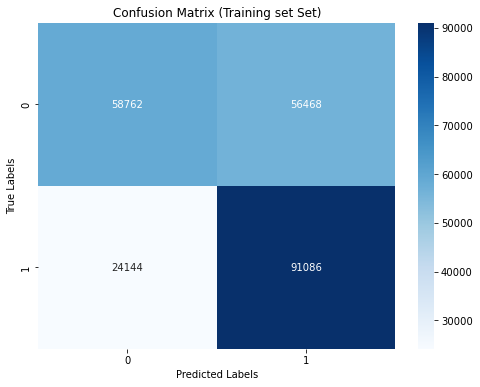

In [53]:
cm_training = confusion_matrix(y_train_smote, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_training, annot=True, fmt='d', cmap='Blues', xticklabels=jan_clf_1.classes_, yticklabels=jan_clf_1.classes_)
plt.title('Confusion Matrix (Training set Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [54]:
y_val_pred = jan_clf_1.predict(X_val)
accuracy_val = round(accuracy_score(y_val, y_val_pred), 2)
print("The accuracy for the training set is :" , accuracy_val)

The accuracy for the training set is : 0.57


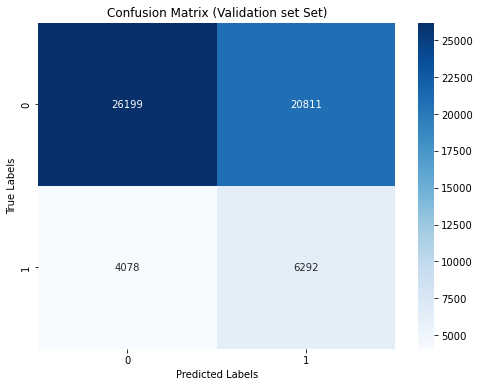

In [55]:
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=jan_clf_1.classes_, yticklabels=jan_clf_1.classes_)
plt.title('Confusion Matrix (Validation set Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [56]:
y_test_pred = jan_clf_1.predict(X_test)
accuracy_test = round(accuracy_score(y_test, y_test_pred), 2)
print("The accuracy for the test set is :" , accuracy_test)

The accuracy for the test set is : 0.56


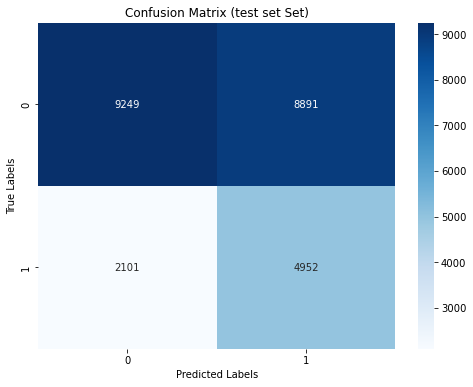

In [57]:
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=jan_clf_1.classes_, yticklabels=jan_clf_1.classes_)
plt.title('Confusion Matrix (test set Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [58]:
#training
y_train_pred = jan_clf_1.predict(X_train_smote)
print("Classification Report (Training Set):")
print(classification_report(y_train_smote, y_train_pred))




Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.71      0.51      0.59    115230
           1       0.62      0.79      0.69    115230

    accuracy                           0.65    230460
   macro avg       0.66      0.65      0.64    230460
weighted avg       0.66      0.65      0.64    230460



In [59]:
# Validation 
y_val_pred = jan_clf_1.predict(X_val)
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))



Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.87      0.56      0.68     47010
           1       0.23      0.61      0.34     10370

    accuracy                           0.57     57380
   macro avg       0.55      0.58      0.51     57380
weighted avg       0.75      0.57      0.62     57380



In [60]:
# Test 
y_test_pred = jan_clf_1.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.51      0.63     18140
           1       0.36      0.70      0.47      7053

    accuracy                           0.56     25193
   macro avg       0.59      0.61      0.55     25193
weighted avg       0.69      0.56      0.58     25193



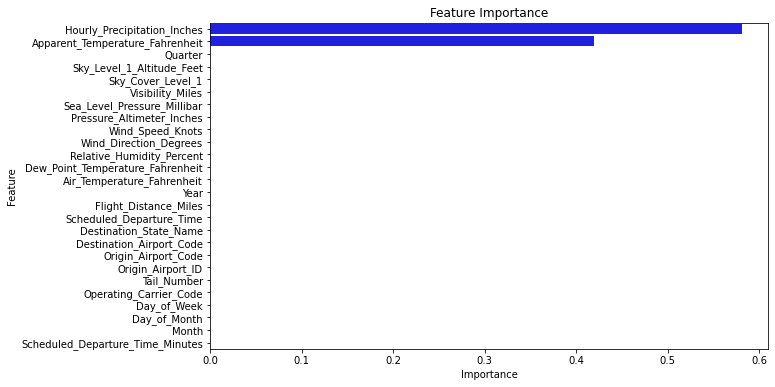

In [61]:

feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': jan_clf_1.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, color='blue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Summary of combined weather and flight data model
- Accuracy for training 0.65 
- Accuracy for validation 0.57
- Accuracy for testing 0.56
### Most Important features
- Hourly Precipitation Inches
- Apparent Temperature Fahrenheit

# Model for flights data only

In [62]:
flights_columns = [
    "Quarter", "Month", "Day_of_Month", "Day_of_Week", "Operating_Carrier_Code", "Tail_Number",
    "Origin_Airport_ID", "Origin_Airport_Code", "Destination_Airport_Code",
    "Destination_State_Name", "Scheduled_Departure_Time", 
    "Flight_Distance_Miles", "Scheduled_Departure_Time_Minutes"
]


In [63]:
X_train_flight = train_df[flights_columns]
y_train_flight = train_df['Target']
X_val_flight = val_df[flights_columns]
y_val_flight = val_df['Target']
X_test_flight = test_df[flights_columns]
y_test_flight = test_df['Target']

In [64]:
X_train_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158523 entries, 0 to 158522
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Quarter                           158523 non-null  int32   
 1   Month                             158523 non-null  int32   
 2   Day_of_Month                      158523 non-null  int32   
 3   Day_of_Week                       158523 non-null  int32   
 4   Operating_Carrier_Code            158523 non-null  category
 5   Tail_Number                       158523 non-null  category
 6   Origin_Airport_ID                 158523 non-null  category
 7   Origin_Airport_Code               158523 non-null  category
 8   Destination_Airport_Code          158523 non-null  category
 9   Destination_State_Name            158523 non-null  category
 10  Scheduled_Departure_Time          158523 non-null  int32   
 11  Flight_Distance_Miles             15852

In [65]:
X_train_flight.head()

,Quarter,Month,Day_of_Month,Day_of_Week,Operating_Carrier_Code,Tail_Number,Origin_Airport_ID,Origin_Airport_Code,Destination_Airport_Code,Destination_State_Name,Scheduled_Departure_Time,Flight_Distance_Miles,Scheduled_Departure_Time_Minutes
0,1,1,1,3,AA,N363AA,13930.0,ORD,MIA,Florida,1715,1197.0,1035
1,1,1,1,3,AA,N372AA,13930.0,ORD,HNL,Hawaii,1100,4243.0,660
2,1,1,1,3,AA,N3AFAA,13930.0,ORD,BOS,Massachusetts,1520,867.0,920
3,1,1,1,3,AA,N3AHAA,13930.0,ORD,FLL,Florida,1900,1182.0,1140
4,1,1,1,3,AA,N3ANAA,13930.0,ORD,MIA,Florida,905,1197.0,545


In [66]:

for col in X_train_flight.select_dtypes(include=['category']).columns:
    X_train_flight[col] = pd.Categorical(X_train_flight[col])
    X_val_flight[col] = pd.Categorical(X_val_flight[col], categories=X_train_flight[col].cat.categories)
    X_test_flight[col] = pd.Categorical(X_test_flight[col], categories=X_train_flight[col].cat.categories)


X_train_flight = X_train_flight.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val_flight = X_val_flight.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test_flight = X_test_flight.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)


C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\282332935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_flight[col] = pd.Categorical(X_train_flight[col])
C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\282332935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_flight[col] = pd.Categorical(X_val_flight[col], categories=X_train_flight[col].cat.categories)
C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\282332935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [67]:

smote = SMOTE(random_state=42)
X_train_flight_smote, y_train_flight_smote = smote.fit_resample(X_train_flight, y_train_flight)

In [68]:

jan_clf_flight = DecisionTreeClassifier(
    max_depth=5,
    max_leaf_nodes=6,
    min_impurity_decrease=0.01,
    random_state=42
)


jan_clf_flight.fit(X_train_flight_smote, y_train_flight_smote)



DecisionTreeClassifier(max_depth=5, max_leaf_nodes=6,
                       min_impurity_decrease=0.01, random_state=42)

In [69]:

y_train_flight_pred = jan_clf_flight.predict(X_train_flight_smote)


accuracy_training_flight = round(accuracy_score(y_train_flight_smote, y_train_flight_pred), 2)

print("The accuracy for the training set is:", accuracy_training_flight)


The accuracy for the training set is: 0.6


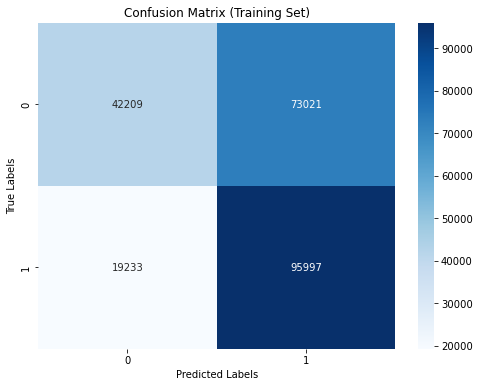

In [70]:
cm_training_flight = confusion_matrix(y_train_flight_smote, y_train_flight_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_training_flight, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_flight.classes_, 
            yticklabels=jan_clf_flight.classes_)
plt.title('Confusion Matrix (Training Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [71]:

y_val_flight_pred = jan_clf_flight.predict(X_val_flight)


accuracy_validation_flight = round(accuracy_score(y_val_flight, y_val_flight_pred), 2)


print("The accuracy for the validation set is:", accuracy_validation_flight)


The accuracy for the validation set is: 0.38


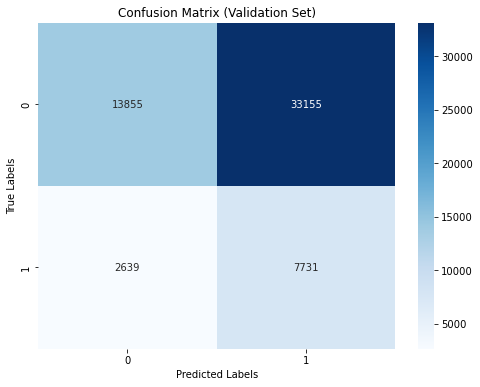

In [72]:
cm_validation_flight = confusion_matrix(y_val_flight, y_val_flight_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_validation_flight, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_flight.classes_, 
            yticklabels=jan_clf_flight.classes_)
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [73]:

y_test_flight_pred = jan_clf_flight.predict(X_test_flight)

accuracy_test_flight = round(accuracy_score(y_test_flight, y_test_flight_pred), 2)


print("The accuracy for the test set is:", accuracy_test_flight)


The accuracy for the test set is: 0.51


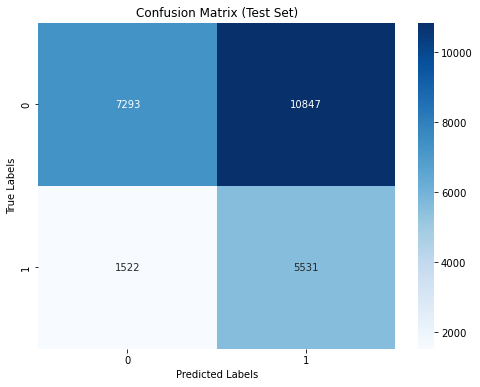

In [74]:

cm_test_flight = confusion_matrix(y_test_flight, y_test_flight_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_flight, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_flight.classes_, 
            yticklabels=jan_clf_flight.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [75]:
y_train_flight_pred = jan_clf_flight.predict(X_train_flight_smote)
print("Classification Report (Training Set - Flight Data):")
print(classification_report(y_train_flight_smote, y_train_flight_pred))

Classification Report (Training Set - Flight Data):
              precision    recall  f1-score   support

           0       0.69      0.37      0.48    115230
           1       0.57      0.83      0.68    115230

    accuracy                           0.60    230460
   macro avg       0.63      0.60      0.58    230460
weighted avg       0.63      0.60      0.58    230460



In [76]:
y_val_flight_pred = jan_clf_flight.predict(X_val_flight)
print("\nClassification Report (Validation Set - Flight Data):")
print(classification_report(y_val_flight, y_val_flight_pred))


Classification Report (Validation Set - Flight Data):
              precision    recall  f1-score   support

           0       0.84      0.29      0.44     47010
           1       0.19      0.75      0.30     10370

    accuracy                           0.38     57380
   macro avg       0.51      0.52      0.37     57380
weighted avg       0.72      0.38      0.41     57380



In [77]:
y_test_flight_pred = jan_clf_flight.predict(X_test_flight)
print("\nClassification Report (Test Set - Flight Data):")
print(classification_report(y_test_flight, y_test_flight_pred))


Classification Report (Test Set - Flight Data):
              precision    recall  f1-score   support

           0       0.83      0.40      0.54     18140
           1       0.34      0.78      0.47      7053

    accuracy                           0.51     25193
   macro avg       0.58      0.59      0.51     25193
weighted avg       0.69      0.51      0.52     25193



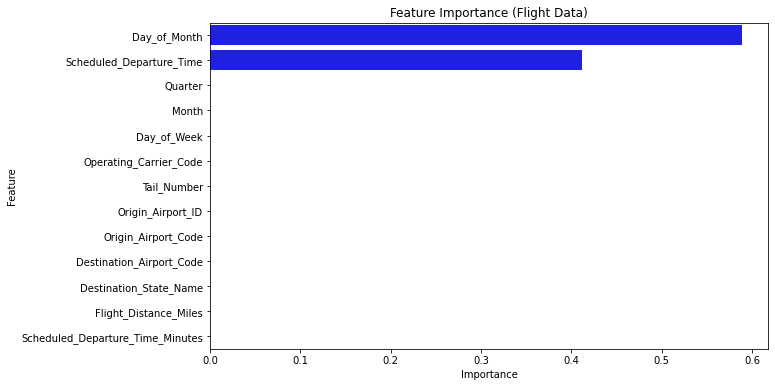

In [78]:
feature_importance_flight = pd.DataFrame({
    'Feature': X_train_flight_smote.columns,
    'Importance': jan_clf_flight.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_flight, color='blue')
plt.title('Feature Importance (Flight Data)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Summary of only flight data model
- Training accuracy 0.6
- Validation accuracy 0.38
- Testing accuracy 0.51

## Most important features
- Day of Month
- Scheduled Departure Time

## Model using only weather data

In [79]:
weather_columns = [
    "Air_Temperature_Fahrenheit", "Dew_Point_Temperature_Fahrenheit",
    "Relative_Humidity_Percent", "Wind_Direction_Degrees", "Wind_Speed_Knots",
    "Hourly_Precipitation_Inches", "Pressure_Altimeter_Inches",
    "Sea_Level_Pressure_Millibar", "Visibility_Miles", "Sky_Cover_Level_1",
    "Sky_Level_1_Altitude_Feet", "Apparent_Temperature_Fahrenheit"
]


In [80]:
X_train_weather = train_df[weather_columns]
y_train_weather = train_df['Target']
X_val_weather = val_df[weather_columns]
y_val_weather = val_df['Target']
X_test_weather = test_df[weather_columns]
y_test_weather = test_df['Target']

In [81]:
X_train_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158523 entries, 0 to 158522
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Air_Temperature_Fahrenheit        158523 non-null  float32 
 1   Dew_Point_Temperature_Fahrenheit  158523 non-null  float32 
 2   Relative_Humidity_Percent         158523 non-null  float32 
 3   Wind_Direction_Degrees            158523 non-null  float32 
 4   Wind_Speed_Knots                  158523 non-null  float32 
 5   Hourly_Precipitation_Inches       158523 non-null  float32 
 6   Pressure_Altimeter_Inches         158523 non-null  float32 
 7   Sea_Level_Pressure_Millibar       158523 non-null  float32 
 8   Visibility_Miles                  158523 non-null  float32 
 9   Sky_Cover_Level_1                 158523 non-null  category
 10  Sky_Level_1_Altitude_Feet         158523 non-null  float32 
 11  Apparent_Temperature_Fahrenheit   15852

In [82]:
X_train_weather.head()

,Air_Temperature_Fahrenheit,Dew_Point_Temperature_Fahrenheit,Relative_Humidity_Percent,Wind_Direction_Degrees,Wind_Speed_Knots,Hourly_Precipitation_Inches,Pressure_Altimeter_Inches,Sea_Level_Pressure_Millibar,Visibility_Miles,Sky_Cover_Level_1,Sky_Level_1_Altitude_Feet,Apparent_Temperature_Fahrenheit
0,21.00,15.00,77.449997,60.0,14.0,0.020000,30.0,1025.099976,0.625,VV,1200.0,7.26
1,14.25,9.25,79.980003,350.0,7.0,0.000000,30.0,1025.099976,7.750,OVC,1300.0,3.17
2,21.00,15.00,77.449997,70.0,12.0,0.026667,30.0,1025.699951,0.750,BKN,1300.0,8.03
3,21.00,15.00,77.449997,50.0,11.0,0.027500,30.0,1024.099976,0.750,VV,1400.0,8.45
4,12.50,7.50,79.830002,270.0,8.0,0.001250,30.0,1025.500000,6.000,OVC,1200.0,0.34


In [83]:

for col in X_train_weather.select_dtypes(include=['category']).columns:
    X_train_weather[col] = pd.Categorical(X_train_weather[col])
    X_val_weather[col] = pd.Categorical(X_val_weather[col], categories=X_train_weather[col].cat.categories)
    X_test_weather[col] = pd.Categorical(X_test_weather[col], categories=X_train_weather[col].cat.categories)

X_train_weather = X_train_weather.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val_weather = X_val_weather.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test_weather = X_test_weather.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)


C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\1109398252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_weather[col] = pd.Categorical(X_train_weather[col])
C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\1109398252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_weather[col] = pd.Categorical(X_val_weather[col], categories=X_train_weather[col].cat.categories)
C:\Users\rezan\AppData\Local\Temp\ipykernel_3232\1109398252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

In [84]:
smote = SMOTE(random_state=42)

X_train_weather_smote, y_train_weather_smote = smote.fit_resample(X_train_weather, y_train_weather)

In [85]:
jan_clf_weather = DecisionTreeClassifier(
    max_depth=5,
    max_leaf_nodes=6,
    min_impurity_decrease=0.01,
    random_state=42
)


jan_clf_weather.fit(X_train_weather_smote, y_train_weather_smote)


DecisionTreeClassifier(max_depth=5, max_leaf_nodes=6,
                       min_impurity_decrease=0.01, random_state=42)

In [86]:
y_train_weather_pred = jan_clf_weather.predict(X_train_weather_smote)

accuracy_training_weather = round(accuracy_score(y_train_weather_smote, y_train_weather_pred), 2)


print("The accuracy for the weather-specific training set is:", accuracy_training_weather)

The accuracy for the weather-specific training set is: 0.62


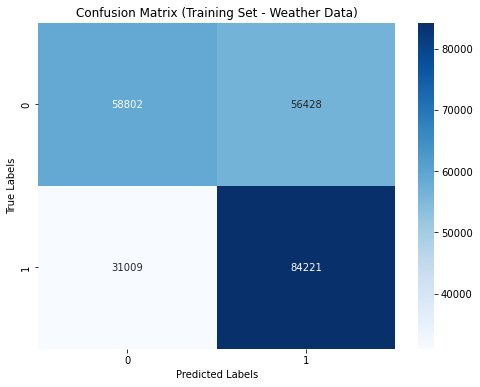

In [87]:
cm_training_weather = confusion_matrix(y_train_weather_smote, y_train_weather_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_training_weather, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_weather.classes_, 
            yticklabels=jan_clf_weather.classes_)
plt.title('Confusion Matrix (Training Set - Weather Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [88]:
y_val_weather_pred = jan_clf_weather.predict(X_val_weather)
accuracy_validation_weather = round(accuracy_score(y_val_weather, y_val_weather_pred), 2)
print("The accuracy for the weather-specific validation set is:", accuracy_validation_weather)

The accuracy for the weather-specific validation set is: 0.57


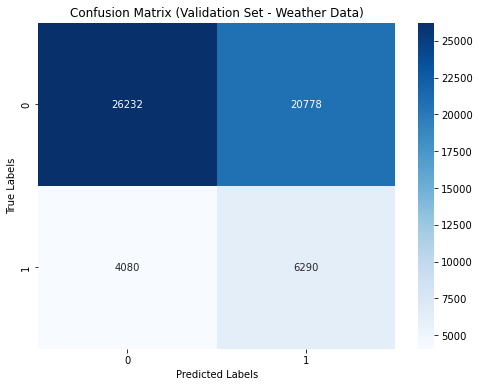

In [89]:
cm_validation_weather = confusion_matrix(y_val_weather, y_val_weather_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_validation_weather, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_weather.classes_, 
            yticklabels=jan_clf_weather.classes_)
plt.title('Confusion Matrix (Validation Set - Weather Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [90]:
y_test_weather_pred = jan_clf_weather.predict(X_test_weather)
accuracy_test_weather = round(accuracy_score(y_test_weather, y_test_weather_pred), 2)
print("The accuracy for the weather-specific test set is:", accuracy_test_weather)

The accuracy for the weather-specific test set is: 0.56


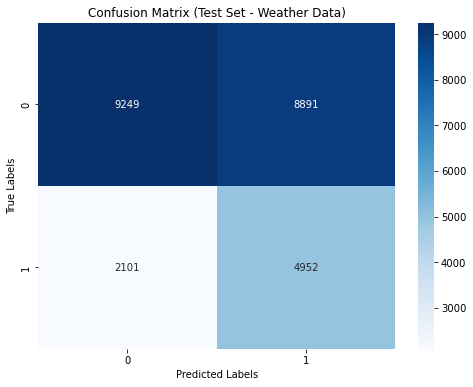

In [91]:
cm_test_weather = confusion_matrix(y_test_weather, y_test_weather_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_weather, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_weather.classes_, 
            yticklabels=jan_clf_weather.classes_)
plt.title('Confusion Matrix (Test Set - Weather Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [92]:
y_train_weather_pred = jan_clf_weather.predict(X_train_weather_smote)
print("Classification Report (Training Set - Weather Data):")
print(classification_report(y_train_weather_smote, y_train_weather_pred))

Classification Report (Training Set - Weather Data):
              precision    recall  f1-score   support

           0       0.65      0.51      0.57    115230
           1       0.60      0.73      0.66    115230

    accuracy                           0.62    230460
   macro avg       0.63      0.62      0.62    230460
weighted avg       0.63      0.62      0.62    230460



In [93]:
y_val_weather_pred = jan_clf_weather.predict(X_val_weather)
print("\nClassification Report (Validation Set - Weather Data):")
print(classification_report(y_val_weather, y_val_weather_pred))


Classification Report (Validation Set - Weather Data):
              precision    recall  f1-score   support

           0       0.87      0.56      0.68     47010
           1       0.23      0.61      0.34     10370

    accuracy                           0.57     57380
   macro avg       0.55      0.58      0.51     57380
weighted avg       0.75      0.57      0.62     57380



In [94]:
y_test_weather_pred = jan_clf_weather.predict(X_test_weather)
print("\nClassification Report (Test Set - Weather Data):")
print(classification_report(y_test_weather, y_test_weather_pred))


Classification Report (Test Set - Weather Data):
              precision    recall  f1-score   support

           0       0.81      0.51      0.63     18140
           1       0.36      0.70      0.47      7053

    accuracy                           0.56     25193
   macro avg       0.59      0.61      0.55     25193
weighted avg       0.69      0.56      0.58     25193



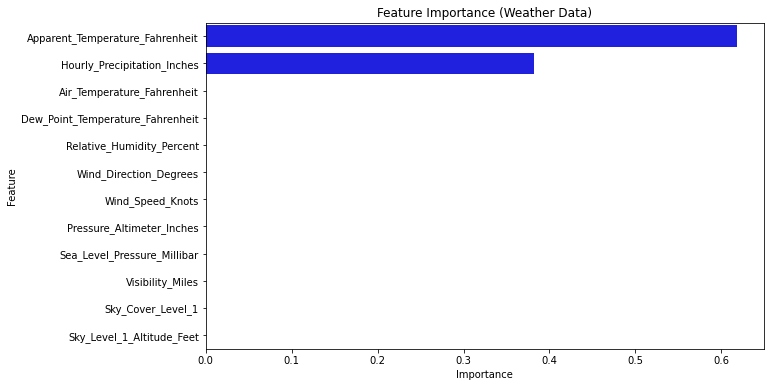

In [95]:
feature_importance_weather = pd.DataFrame({
    'Feature': X_train_weather_smote.columns,
    'Importance': jan_clf_weather.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_weather, color='blue')
plt.title('Feature Importance (Weather Data)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Summary of the weather only data model
- Training Accuracy 0.62
- Validation Accuracy 0.57
- Testing Accuracy 0.56

## Most important features
- Apparent Temperature Fahrenheit
- Hourly Precipitation Inches
